# Data import and exploration
This notebook goes through two options for data import and exploration.
* Pandas
* Numpy

## First, look at the data
Sean Liddick provided information about how the file is formatted:

The file contains one event per line, including the event energies and positions.
The values are space-separated. The first 256 values correspond to the 16x16 detector image, flattened. 
The next values are, in order:
Energy1, Xpos1, Ypos1, Energy2, Xpos2, Ypos2
There are two types of events in the dataset. Single and double.\
For single events Xpos2 and Ypos2 are set to -100 instead of 0 to make a clear distinction.

Open up the file and look at it. In most linux terminals you can also use the command
`head` to display a set number of lines from the start of the file. We'll start with the first line.
Usually you will also have some information about the file formatting.
You can run shell commands inside the notebook by starting the line with an exclamation mark.

In [2]:
!head -1 ../data/CeBr10k_1.txt

53 81 96 117 175 194 229 221 179 112 112 80 74 51 36 29 73 92 140 187 253 385 480 395 298 221 145 101 73 59 52 43 64 131 165 261 405 760 1161 864 458 275 180 101 97 68 60 41 79 126 171 287 654 1808 4037 2244 759 350 197 133 86 78 58 35 75 130 153 324 731 2248 6480 3036 889 358 170 116 105 101 65 39 67 127 171 270 559 1158 1840 1324 618 287 172 103 104 78 75 39 48 95 120 185 366 485 628 496 360 213 152 111 90 70 69 36 58 73 109 149 157 229 280 268 243 172 142 106 81 73 73 40 44 66 88 115 126 148 125 156 118 127 122 119 103 108 87 73 34 49 68 71 104 112 117 107 100 108 128 138 172 134 142 93 37 46 54 52 66 67 88 91 98 109 151 210 284 309 234 144 22 47 43 56 69 63 63 68 109 113 177 372 743 781 429 228 18 34 42 42 40 59 57 76 70 118 220 541 1633 1769 543 230 32 33 36 46 42 46 56 64 74 93 207 435 935 957 501 204 12 34 28 38 37 35 45 59 82 98 154 251 343 393 256 173 13 21 27 34 36 37 27 35 42 63 109 144 162 191 136 115 0.942514 4.30804 6.70703 0.33576 12.6208 13.0421




That last bit of information indicates that the event we printed above is a double event.
We also note that the 256 "pixel" values in the detector image are integers, while the remaining
6 values for energy and position are floats.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline


## Import with Pandas

## Import with Numpy



Check the "helper_functions.py" file in the notebook folder to see how we handle the import.
The approach used here is a very direct and specific one, but import can be done with any tool you prefer, for example pandas.

The energy units are MeV, and the position units are in pixels.

In the import function we reshape the images to add another dimension. This is the "channels"
dimension that models will expect. If the images were RGB images, an image would be (16, 16, 3),
but we only have one channel, so we shape them to be (16, 16, 1).

In [2]:
# CeBr10k_1.txt -> mixed single and double events 
DATA_PATH = "../data/"
fname = "CeBr10k_1.txt"

images, energies, positions, labels = import_data(DATA_PATH + fname)

# If you have done this before, and have saved data as numpy files, you
# can skip this and import directly with numpy.Comment the line above
# images = np.load(DATA_PATH+"images_training.npy")
# energies = np.load(DATA_PATH+"energies_training.npy")
# positions = np.load(DATA_PATH+"positions_training.npy")
# labels = np.load(DATA_PATH+"labels_training.npy")

print("Images shape: {}".format(images.shape))
print("Energies shape: {}".format(energies.shape))
print("Positions shape: {}".format(positions.shape))
print("Labels shape: {}".format(labels.shape))
print("Number of events of each class:", np.unique(labels, return_counts=True))


Images shape: (10000, 16, 16, 1)
Energies shape: (10000, 2)
Positions shape: (10000, 4)
Labels shape: (10000,)
Number of events of each class: (array([0, 1]), array([5002, 4998]))


## Inspection of imported data
If possible, it's usually a good idea to have a look at the data to confirm that
the import gives a correct representation. In this case we want to check that the
images look reasonable and match with positions and label.

In [3]:
print("Label of image 0:", labels[0])
print("Positions:", positions[0])
print("Energies:", energies[0])
print("\nLabel of image 1:", labels[1])
print("Positions:", positions[1])
print("Energies:", energies[1])

Label of image 0: 1
Positions: [ 4.30804  6.70703 12.6208  13.0421 ]
Energies: [0.942514 0.33576 ]

Label of image 1: 0
Positions: [  12.7629     1.52259 -100.      -100.     ]
Energies: [0.302704 0.      ]


So we have two events. One double event and one single event.
We can plot the detector images using matplotlib's imshow. You could also use a module called
seaborn, which comes with a lot of nice presets to make many scientific plots good-looking by
default. Seaborn also works well with pandas if you're using that.

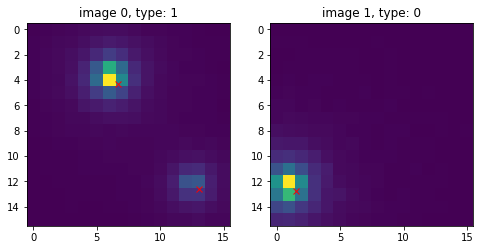

In [4]:
# Plot detector image, including positions.
# Note that the indices of the positions are swapped when plotting.
# imshow plots using matrix coordinates (row first), while our data
# comes as column first.
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(images[0].reshape((16, 16)))
ax[0].set_title("image 0, type: " + str(labels[0]))
ax[0].plot(positions[0, 1], positions[0, 0], 'rx')
ax[0].plot(positions[0, 3], positions[0, 2], 'rx')

ax[1].imshow(images[1].reshape((16, 16)))
ax[1].set_title("image 1, type: " + str(labels[1]))
ax[1].plot(positions[1, 1], positions[1, 0], 'rx')


### Seaborn example
Seaborn example using heatmap. Note the colorbar on the right of the images
includes information about the pixel intensity in the detector image. (You can add
color bars to imshow too, seaborn just does it by default).
Comparing with the energies printed above, higher energy corresponds to higher intensity,
as expected.

We have to reshape the images back to (16, 16) to plot them, so we do that for the
specific images we need. This is temporary, and doesn't actually change the images that
is stored in the "images" array.

Text(0.5, 1.0, 'image 1, type: 0')

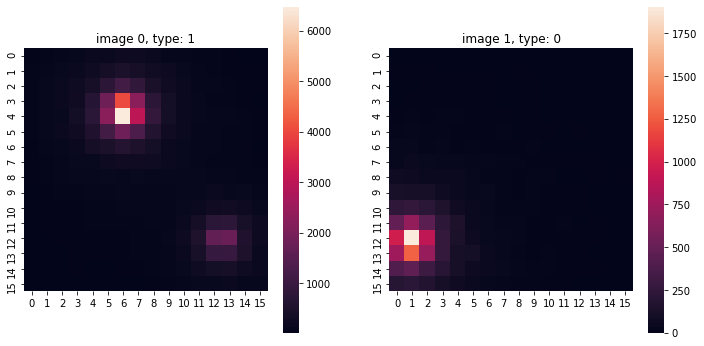

In [5]:
import seaborn as sns
fig1, ax1 = plt.subplots(1,2, figsize=(12, 6))
sns.heatmap(images[0].reshape((16, 16)), ax=ax1[0], square=True)
ax1[0].set_title("image 0, type: " + str(labels[0]))

sns.heatmap(images[1].reshape((16, 16)), ax=ax1[1], square=True)
ax1[1].set_title("image 1, type: " + str(labels[1]))

## Looking further into the detector images
From the pixel intensities above we can see that there's quite some difference in
intensity. This may affect the model's ability to learn. We delve a little deeper into the numbers, 
by checking the maximum, minimum, and mean pixel intensity.

In [6]:
p_max = np.amax(images)
p_min = np.amin(images)
p_mean = np.mean(images)
print("Image max:", p_max)
print("Image min:", p_min)
print("Image mean:", p_mean)

Image max: 9951.0
Image min: 0.0
Image mean: 157.71130703125


The maximum pixel value is almost two orders of magnitude higher than the mean.
This may warrant exploring log-scaling the data later down the road, but to start with,
we're going to min-max scale the data to the [0, 1] interval.

## Normalization of image data
Min-max scaling preserves the shape of the distribution, so that the difference between each image in
a set of images is also preserved. In doing so, we are assuming that this property in the data is important,
but keep in mind that it is something we can change, should we want to.
Min-max scaling is calculated as
$$\text{scaled image} = \frac{\text{image} - \mu_{image}}{I_{max} - I_{min}},$$
where $I_{max}$ and $I_{min}$ refer to the maximum and minimum pixel intensity,
and $\mu_{image}$ is the mean pixel intensity for the set of images.

We've implemented this as a function `normalize_image_data()` using numpy, in `helper_functions.py`.
We are, however, not going to use it quite yet. We won't normalize the data before we've split it into
a training set and a validation set. If we normalize the entire dataset, then split it, we've techinically
included properties of the validation set in the training set. This can give you a false picture of how well
your model is performing, and should be avoided. To be even more rigorous, we take out a small "test set", which
we stow away until we believe our model is the best it can be. Then we assess the performance on this small
test set, as our "out of sample" performance.

## Preparing the data
You can do the splitting of data manually by slicing the arrays. But this is Python and there are so many
modules that can do this for us, just make sure to check the documentation so you don't get any surprises. 
For this example, we're using scikit-learn's `train_test_split` function, which also shuffles the data for us.
Instead of creating copies of the dataset, filling up often precious memory, we will work with indices that we
pass around. This also makes it easier to trace any results back to the original inputs.


### Save training and test sets as files
At this point, to keep training data persistent, and to stow away the test set for when all the training
and tweaking is done, you can save the training and test data as numpy files to avoid having to read
the datafile every time. This is especially useful when the datafiles get into the Gigabytes range.

In [7]:
# Indices for all images
x_idx = np.arange(images.shape[0])

# Split the indices into training and test sets (take out 10% of the data as test)
tmp_train_idx, test_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.1)

# Save the training and test data in the data folder
# We also need to save the labels, energies, and positions. This allows us to
# quickly load it if we need it.

# Save the training data. np.save adds a ".npy" file extension to the provided filename.
# We save the files in the same folder as the original datafile.
np.save(DATA_PATH+"images_training", images[tmp_train_idx])
np.save(DATA_PATH+"energies_training", energies[tmp_train_idx])
np.save(DATA_PATH+"positions_training", positions[tmp_train_idx])
np.save(DATA_PATH+"labels_training", labels[tmp_train_idx])

# Save the test data
np.save(DATA_PATH+"images_test", images[test_idx])
np.save(DATA_PATH+"energies_test", energies[test_idx])
np.save(DATA_PATH+"positions_test", positions[test_idx])
np.save(DATA_PATH+"labels_test", labels[test_idx])

### Prepare training data from numpy file
This assumes you've already saved the data using the codecell above. Some steps from that cell are now repeated,
but with a different goal - to prepare for training, not saving.

In [39]:
images = np.load(DATA_PATH+"images_200k.npy")
labels = np.load(DATA_PATH+"labels_200k.npy")

# Split the training indices into training and validation. 
# Validate with 25% of the data (default). Can be adjusted as you see fit.
x_idx = np.arange(images.shape[0])
train_idx, val_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.25)